In [1]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [2]:
# Carregar datasets
dataset = pd.read_csv('dataset.csv')
features = pd.read_csv('just_features.csv')

In [3]:
# Visualizar os dados carregados
print("Dataset:")
print(dataset.head())

Dataset:
      genero estado_civil zona_residencia   imc fumador       class_etaria  \
0  masculino       casado       suburbana  35.8     sim  adulto_meia_idade   
1   feminino     separado          urbana  39.3     nao      adulto_senior   
2  masculino     solteiro           rural  40.7     nao              jovem   
3  masculino       casado          urbana  28.2     sim  adulto_meia_idade   
4   feminino     solteiro          urbana  31.1     nao      adulto_senior   

     custo  
0  18213.9  
1   4266.4  
2    854.6  
3  10169.7  
4   4151.5  


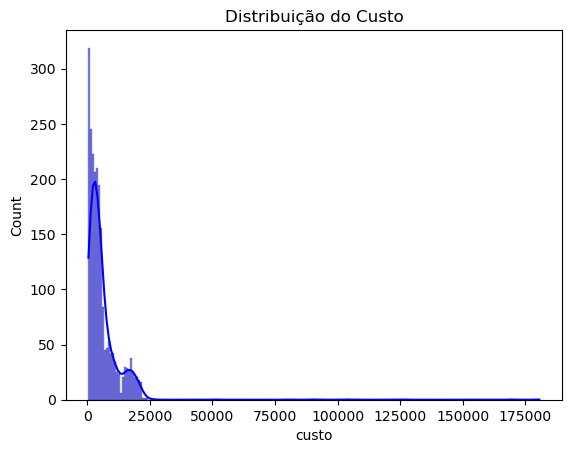

In [4]:
# Visualizar a distribuição do custo
sns.histplot(dataset['custo'], kde=True, color='blue')
plt.title("Distribuição do Custo")
plt.show()

In [5]:
# Função para tratamento de outliers usando IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [6]:
# Remover outliers na variável 'custo' e 'imc'
dataset = remove_outliers(dataset, 'custo')
dataset = remove_outliers(dataset, 'imc')

In [7]:
# Separar features e target
X = dataset.drop(columns=['custo'])
y = dataset['custo']

In [8]:
# Identificar colunas categóricas e numéricas
categorical_features = ['genero', 'estado_civil', 'zona_residencia', 'fumador', 'class_etaria']
numerical_features = ['imc']

In [9]:
# Configurar transformadores
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [10]:
# Criar o preprocessador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [11]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Pipeline para Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [13]:
# Configurar GridSearch para Random Forest
param_grid_rf = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

In [14]:
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='r2', verbose=2)


In [15]:
# Treinar Random Forest com GridSearch
print("Treinando Random Forest com ajuste fino...")
grid_search_rf.fit(X_train, y_train)

Treinando Random Forest com ajuste fino...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=200; total time=   0.3s
[CV] END regressor__max_d

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['imc']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['genero',
                                                                          'estado_civil',
                                                                          'zona_residencia',
                                                                          'fumador',
                                                                          'class_etaria'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [10, 20, None],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [100, 200, 300]},
             scoring='r2', verbose=2)

In [16]:
# Melhor modelo Random Forest
best_rf = grid_search_rf.best_estimator_
print(f"Melhores hiperparâmetros RF: {grid_search_rf.best_params_}")

Melhores hiperparâmetros RF: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}


In [17]:
# Avaliação do modelo Random Forest
y_pred_rf = best_rf.predict(X_test)
score_rf = r2_score(y_test, y_pred_rf)
print(f"R² Score com Random Forest (ajustado): {score_rf}")

R² Score com Random Forest (ajustado): 0.6730501427362535


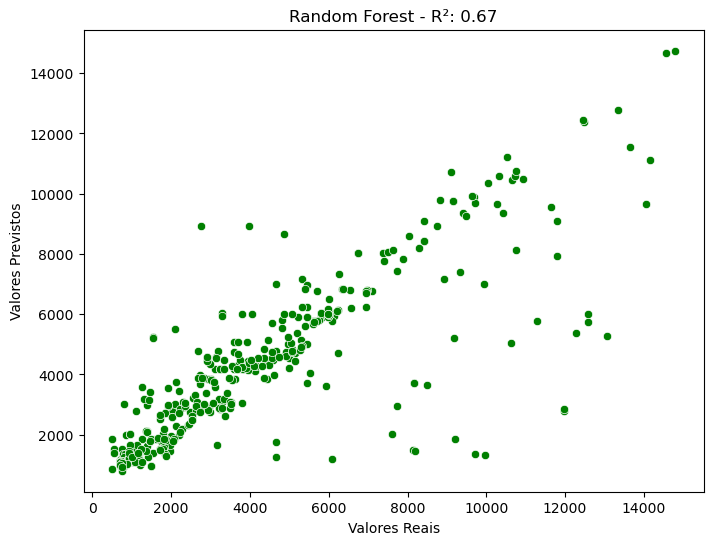

In [18]:
# Comparação gráfica entre valores reais e previstos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, color='green')
plt.xlabel("Valores Reais")
plt.ylabel("Valores Previstos")
plt.title(f"Random Forest - R²: {score_rf:.2f}")
plt.show()


Importância das Features:
                           Feature  Importance
11        class_etaria_adolescente    0.208989
0                  genero_feminino    0.192589
10                     fumador_sim    0.187232
16              class_etaria_jovem    0.093420
15              class_etaria_idoso    0.092827
5               estado_civil_viuvo    0.064745
3            estado_civil_separado    0.033683
14      class_etaria_adulto_senior    0.032670
4            estado_civil_solteiro    0.019089
7        zona_residencia_suburbana    0.017503
13  class_etaria_adulto_meia_idade    0.014912
8           zona_residencia_urbana    0.009862
9                      fumador_nao    0.007264
2              estado_civil_casado    0.006616
1                 genero_masculino    0.006607
6            zona_residencia_rural    0.005938
17                             imc    0.004267
12       class_etaria_adulto_jovem    0.001786


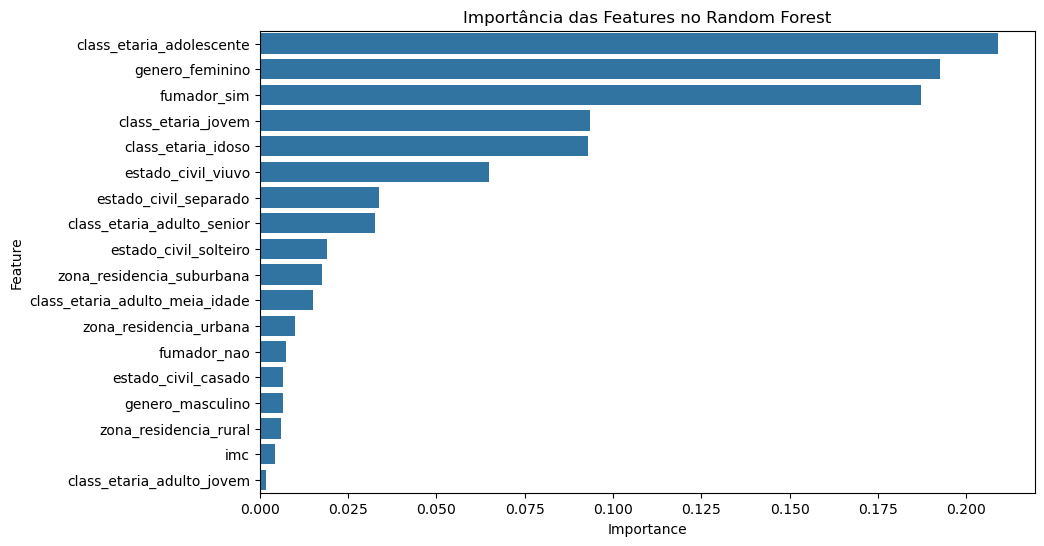

In [19]:
# Visualizar a importância das features
feature_importances = best_rf.named_steps['regressor'].feature_importances_

# Obter nomes das features do preprocessador
cat_features = best_rf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
num_features = numerical_features  # Features numéricas não transformadas

# Combinar nomes das features
feature_names = np.concatenate([cat_features, num_features])

# Criar DataFrame com as importâncias
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Ordenar pelas importâncias
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Exibir as importâncias
print("\nImportância das Features:")
print(importances_df)

# Plotar as importâncias
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title("Importância das Features no Random Forest")
plt.show()


In [20]:
# Prever os custos para novos dados (just_features.csv)
predictions = best_rf.predict(features)
predictions_df = pd.DataFrame(predictions, columns=['custo'])
predictions_df.to_csv('grupo#_custos_estimados.csv', index=False)
print("Predições salvas no arquivo 'grupo#_custos_estimados.csv'")

Predições salvas no arquivo 'grupo#_custos_estimados.csv'
